In [1]:
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns

Попробовал оптимизировать несколько метрик, на мой взгляд лучше всего работает L1 норма с небольшим штрафом за значения в матрице корреляций противоположного знака с R 

Если сделать большой штраф за отрицательные значения, то матрица в какой-то момент пререстанет подбираться и значение дисперсии будет делако от теоретического

In [2]:
m = 200
n = 100
p = 0.04
R = 0.01

N_ITERATIONS = 1 * 10 ** 5

In [3]:
# матрица корреляций, которую хотим получить
required_matrix = np.ones([n, n]) * R - np.diag([R - 1] * n)

# начальная матрица до переставления элементов
n_ones = round(p * m)
n_zeros = round(m * (1 - p))
start_matrix = np.concatenate([np.ones(n_ones), np.zeros(n_zeros)] * n).reshape(n, m).T

In [4]:
def true_var(p, R, n, m):
    var = n * p * (1 - p) * (1 + (n - 1) * R)
    return var

In [5]:
def RMSE(matrix):
    corr_mat = np.corrcoef(matrix, rowvar=False)
    corr_mat = np.where(corr_mat * R < 0, corr_mat * 3, corr_mat)
    return np.mean((corr_mat - required_matrix) ** 2)


def MAE(matrix):
    corr_mat = np.corrcoef(matrix, rowvar=False)
    corr_mat = np.where(corr_mat * R < 0, corr_mat * 3, corr_mat)
    return np.mean(np.abs((corr_mat - required_matrix)))


def L1(matrix):
    corr_mat = np.corrcoef(matrix, rowvar=False)
    corr_mat = np.where(corr_mat * R < 0, corr_mat * 3, corr_mat)
    return np.linalg.norm(corr_mat - required_matrix)

In [6]:
loss_func = L1


def group_swap(arr, loss):
# алгоритм по замене двух рандомных элементов местами
    arr1 = arr.copy()
    r_col = np.random.randint(n)
    r_row_1 = np.random.randint(m)
    r_row_2 = np.random.randint(m)
    arr1[r_row_1][r_col], arr1[r_row_2][r_col] = arr1[r_row_2][r_col], arr1[r_row_1][r_col]
    new_loss =  loss_func(arr1)
    if new_loss < loss:
        return arr1, new_loss
    else: 
        return arr, loss

<AxesSubplot:ylabel='Density'>

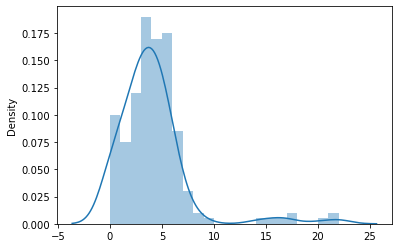

In [10]:
t_var = round(true_var(p, R, n, m), 2)
new_loss = loss_func(start_matrix)
new_mat = start_matrix

with tqdm(range(N_ITERATIONS)) as t:
    for i in t:
        t.set_description(f'theoretical var: {t_var}')  
        new_var = np.var(new_mat.sum(axis=1))
        t.set_postfix(loss=new_loss, var=new_var)   
        new_mat, new_loss = group_swap(new_mat, new_loss)
#         if new_var < t_var:
#             break
new_mean = np.mean(new_mat.sum(axis=1))
print(f'var: {new_var}, mean: {new_mean}')